In [11]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import bootstrap

In [12]:
# colors = [
#     '#1f77b4',  # Blue
#     '#ff7f0e',  # Orange
#     '#2ca02c',  # Green
#     '#d62728',  # Red
#     '#9467bd',  # Purple
#     '#8c564b',  # Brown
#     '#e377c2',  # Pink
#     '#7f7f7f',  # Gray
#     '#bcbd22',  # Yellow-Green
#     '#17becf'   # Cyan
# ]

In [13]:
# Load the data from the CSV file to inspect its contents
file_path = './reports.csv'
report = pd.read_csv(file_path)

# Display the 'OPENFOAM_WORKSPACE_DIR' column fully without truncation
pd.set_option('display.max_colwidth', None)

# Display the first few rows of the data to understand its structure
report.head()

,OPENFOAM_WORKSPACE_DIR,YPLUS_MIN,YPLUS_MAX,YPLUS_AVG,CA_FINAL_COEFF,CN_FINAL_COEFF,CM_FINAL_COEFF,CA_FINAL_COEFF_WINDOW,CN_FINAL_COEFF_WINDOW,CM_FINAL_COEFF_WINDOW,...,residual_p,log.decomposePar,residual_Uy,residual_Ux,residual_k,log.rhoCentralFoam,log.rhoPimpleFoam,residual_Uz,residual_omega,log.mapFields
0,D:\sim\convergence_Ma0.6_AoA8_rhoPimpleFoam\Ma0.6_AoA8_R2_rhoPimpleFoam,0.000102,0.843450,0.264353,0.306690,0.310082,3.429177,0.306628,0.309873,3.428824,...,0.000002,1,1.763573e-07,8.112653e-09,8.594039e-09,NaN,0.0,6.292154e-08,7.409846e-13,NaN
1,D:\sim\convergence_Ma0.6_AoA8_rhoPimpleFoam\Ma0.6_AoA8_R3_rhoPimpleFoam,0.005777,1.834531,0.485299,0.301450,0.294532,3.436073,0.301631,0.293805,3.435684,...,0.000002,1,3.770611e-07,1.919298e-08,1.447199e-08,NaN,1.0,1.537637e-07,4.501601e-11,NaN
2,D:\sim\convergence_Ma1.5_AoA0_rhoPimpleFoam\Ma1.5_AoA0_R2_rhoPimpleFoam,0.000089,0.486806,0.151765,0.285508,-0.000611,-0.001517,0.284108,-0.000495,-0.001834,...,0.000094,1,9.026592e-07,9.737097e-09,4.145121e-09,NaN,1.0,5.952972e-05,3.492564e-10,NaN
3,D:\sim\convergence_Ma1.5_AoA0_rhoPimpleFoam\Ma1.5_AoA0_R3_rhoPimpleFoam,0.001847,1.000567,0.323766,0.303084,0.000053,-0.008585,0.302357,-0.000304,-0.008323,...,0.000036,1,2.260731e-06,3.885377e-08,4.831528e-09,NaN,1.0,6.818529e-05,5.776521e-12,NaN
4,D:\sim\convergence_Ma1.5_AoA0_rhoPimpleFoam\Ma1.5_AoA0_R4_rhoPimpleFoam,0.001864,1.061797,0.218455,0.307275,-0.000754,-0.006002,0.307007,-0.000907,-0.006942,...,0.000024,1,3.906486e-06,5.110995e-08,6.360556e-09,NaN,1.0,4.915560e-05,4.677396e-12,NaN


In [14]:
# Function to extract Mach number from the OPENFOAM_WORKSPACE_DIR column
def extract_mach_number(path):
    match = re.search(r'Ma(\d+\.\d+)', path)
    if match:
        return float(match.group(1))
    return None

# Apply the function to extract Mach number and create a new column for Mach
report['Mach'] = report['OPENFOAM_WORKSPACE_DIR'].apply(extract_mach_number)

# Drop rows where Mach could not be extracted
report = report.dropna(subset=['Mach'])

# Function to extract grid refinement level (R1, R2, etc.) from the path
def extract_refinement_level(path):
    match = re.search(r'_R(\d)', path)
    if match:
        return f"R{match.group(1)}"
    return None

# Apply functions to create new columns for grid refinement
report['Grid_Refinement'] = report['OPENFOAM_WORKSPACE_DIR'].apply(extract_refinement_level)

# Function to extract angle of attack (AoA) from the path
def extract_aoa(path):
    match = re.search(r'AoA(\d+)', path)
    if match:
        return int(match.group(1))
    return None

# Apply functions to create new columns for AoA
report['AoA'] = report['OPENFOAM_WORKSPACE_DIR'].apply(extract_aoa)

# Assuming data is already loaded into a DataFrame named 'data'
# Extract solver names (rhoPimpleFoam or rhoCentralFoam) from 'OPENFOAM_WORKSPACE_DIR' column
report['Solver'] = report['OPENFOAM_WORKSPACE_DIR'].str.extract(r'(rhoPimpleFoam|rhoCentralFoam)')[0]

# Prepare markers and colors for distinguishing grid refinement levels and AoA
markersdict = {'R1': 'o', 'R2': 's', 'R3': '^', 'R4': 'D', 'R5': 'P'}
colors = {0: 'blue', 8: 'green', 10: 'red'}

report

,OPENFOAM_WORKSPACE_DIR,YPLUS_MIN,YPLUS_MAX,YPLUS_AVG,CA_FINAL_COEFF,CN_FINAL_COEFF,CM_FINAL_COEFF,CA_FINAL_COEFF_WINDOW,CN_FINAL_COEFF_WINDOW,CM_FINAL_COEFF_WINDOW,...,residual_k,log.rhoCentralFoam,log.rhoPimpleFoam,residual_Uz,residual_omega,log.mapFields,Mach,Grid_Refinement,AoA,Solver
0,D:\sim\convergence_Ma0.6_AoA8_rhoPimpleFoam\Ma0.6_AoA8_R2_rhoPimpleFoam,0.000102,0.843450,0.264353,0.306690,0.310082,3.429177,0.306628,0.309873,3.428824,...,8.594039e-09,NaN,0.0,6.292154e-08,7.409846e-13,NaN,0.60,R2,8,rhoPimpleFoam
1,D:\sim\convergence_Ma0.6_AoA8_rhoPimpleFoam\Ma0.6_AoA8_R3_rhoPimpleFoam,0.005777,1.834531,0.485299,0.301450,0.294532,3.436073,0.301631,0.293805,3.435684,...,1.447199e-08,NaN,1.0,1.537637e-07,4.501601e-11,NaN,0.60,R3,8,rhoPimpleFoam
2,D:\sim\convergence_Ma1.5_AoA0_rhoPimpleFoam\Ma1.5_AoA0_R2_rhoPimpleFoam,0.000089,0.486806,0.151765,0.285508,-0.000611,-0.001517,0.284108,-0.000495,-0.001834,...,4.145121e-09,NaN,1.0,5.952972e-05,3.492564e-10,NaN,1.50,R2,0,rhoPimpleFoam
3,D:\sim\convergence_Ma1.5_AoA0_rhoPimpleFoam\Ma1.5_AoA0_R3_rhoPimpleFoam,0.001847,1.000567,0.323766,0.303084,0.000053,-0.008585,0.302357,-0.000304,-0.008323,...,4.831528e-09,NaN,1.0,6.818529e-05,5.776521e-12,NaN,1.50,R3,0,rhoPimpleFoam
4,D:\sim\convergence_Ma1.5_AoA0_rhoPimpleFoam\Ma1.5_AoA0_R4_rhoPimpleFoam,0.001864,1.061797,0.218455,0.307275,-0.000754,-0.006002,0.307007,-0.000907,-0.006942,...,6.360556e-09,NaN,1.0,4.915560e-05,4.677396e-12,NaN,1.50,R4,0,rhoPimpleFoam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,D:\sim\rhoPimpleFoam\R1\Ma2.3_AoA16_R1_rhoPimpleFoam,0.085951,66.353201,17.503139,0.350832,2.602437,12.602055,0.350854,2.602384,12.602385,...,4.286853e-08,NaN,1.0,4.154935e-07,3.698003e-10,NaN,2.30,R1,16,rhoPimpleFoam
70,D:\sim\rhoPimpleFoam\R1\Ma2.3_AoA8_R1_rhoPimpleFoam,0.087056,56.958329,17.523857,0.337326,0.577337,4.224774,0.337332,0.577567,4.224886,...,1.444832e-08,NaN,1.0,4.630210e-07,1.886851e-10,NaN,2.30,R1,8,rhoPimpleFoam
71,D:\sim\rhoPimpleFoam\R1\Ma4.63_AoA0_R1_rhoPimpleFoam,0.006824,44.326077,7.696415,0.180920,-0.000092,0.000360,0.180962,-0.000130,0.000112,...,6.866164e-10,NaN,0.0,7.248462e-06,8.197878e-12,NaN,4.63,R1,0,rhoPimpleFoam
72,D:\sim\rhoPimpleFoam\R1\Ma4.63_AoA16_R1_rhoPimpleFoam,0.024989,128.495757,9.155424,0.264325,2.772080,11.167811,0.264349,2.772100,11.166913,...,3.683666e-10,NaN,1.0,7.820306e-09,8.934831e-13,NaN,4.63,R1,16,rhoPimpleFoam


In [15]:
data_alpha_0  = report[report['AoA']==0]
data_alpha_8  = report[report['AoA']==8]
data_alpha_16 = report[report['AoA']==16]

In [16]:
data_alpha_0

,OPENFOAM_WORKSPACE_DIR,YPLUS_MIN,YPLUS_MAX,YPLUS_AVG,CA_FINAL_COEFF,CN_FINAL_COEFF,CM_FINAL_COEFF,CA_FINAL_COEFF_WINDOW,CN_FINAL_COEFF_WINDOW,CM_FINAL_COEFF_WINDOW,...,residual_k,log.rhoCentralFoam,log.rhoPimpleFoam,residual_Uz,residual_omega,log.mapFields,Mach,Grid_Refinement,AoA,Solver
2,D:\sim\convergence_Ma1.5_AoA0_rhoPimpleFoam\Ma1.5_AoA0_R2_rhoPimpleFoam,0.000089,0.486806,0.151765,0.285508,-0.000611,-0.001517,0.284108,-0.000495,-0.001834,...,4.145121e-09,NaN,1.0,5.952972e-05,3.492564e-10,NaN,1.50,R2,0,rhoPimpleFoam
3,D:\sim\convergence_Ma1.5_AoA0_rhoPimpleFoam\Ma1.5_AoA0_R3_rhoPimpleFoam,0.001847,1.000567,0.323766,0.303084,0.000053,-0.008585,0.302357,-0.000304,-0.008323,...,4.831528e-09,NaN,1.0,6.818529e-05,5.776521e-12,NaN,1.50,R3,0,rhoPimpleFoam
4,D:\sim\convergence_Ma1.5_AoA0_rhoPimpleFoam\Ma1.5_AoA0_R4_rhoPimpleFoam,0.001864,1.061797,0.218455,0.307275,-0.000754,-0.006002,0.307007,-0.000907,-0.006942,...,6.360556e-09,NaN,1.0,4.915560e-05,4.677396e-12,NaN,1.50,R4,0,rhoPimpleFoam
14,D:\sim\rhoCentralFoam\R5\Ma0.6_AoA0_R5_rhoCentralFoam,0.005817,1.348805,0.273645,0.271744,-0.001484,-0.000709,0.271774,-0.000841,0.000504,...,2.262950e-06,1.0,NaN,1.136280e-06,9.017220e-11,NaN,0.60,R5,0,rhoCentralFoam
17,D:\sim\rhoCentralFoam\R5\Ma1.0_AoA0_R5_rhoCentralFoam,0.002610,1.218078,0.256547,0.511047,-0.000156,0.003654,0.510856,0.000070,0.000579,...,2.424410e-07,1.0,NaN,6.536500e-06,1.098770e-10,NaN,1.00,R5,0,rhoCentralFoam
20,D:\sim\rhoCentralFoam\R5\Ma1.5_AoA0_R5_rhoCentralFoam,0.002470,0.894607,0.189354,0.481474,0.000103,0.000832,0.481474,0.000086,0.000680,...,2.989840e-07,1.0,NaN,7.677610e-06,1.990390e-10,NaN,1.50,R5,0,rhoCentralFoam
23,D:\sim\rhoCentralFoam\R5\Ma2.3_AoA0_R5_rhoCentralFoam,0.001963,0.526725,0.114454,0.345120,0.000095,-0.000234,0.345413,-0.000023,0.000068,...,2.778870e-07,1.0,NaN,7.923890e-06,2.422130e-10,NaN,2.30,R5,0,rhoCentralFoam
26,D:\sim\rhoCentralFoam\R5\Ma4.63_AoA0_R5_rhoCentralFoam,0.000533,0.141986,0.031155,0.184542,0.000059,0.000057,0.184810,0.000063,0.000117,...,6.699570e-07,1.0,NaN,3.128300e-06,1.726650e-09,NaN,4.63,R5,0,rhoCentralFoam
29,D:\sim\rhoCentralFoam\R1\Ma0.6_AoA0_R1_rhoCentralFoam,0.220505,74.663257,33.025215,0.372827,0.000110,-0.002218,0.372694,0.000637,-0.001269,...,1.642400e-08,1.0,NaN,1.564210e-07,9.614820e-08,NaN,0.60,R1,0,rhoCentralFoam
32,D:\sim\rhoCentralFoam\R1\Ma1.0_AoA0_R1_rhoCentralFoam,0.285007,63.677454,29.261454,0.483324,0.000396,0.002310,0.483383,0.000254,0.000734,...,4.079070e-09,1.0,NaN,3.553700e-07,2.012950e-08,NaN,1.00,R1,0,rhoCentralFoam


In [17]:
# Load the data from the uploaded CSV file
file_path = './CA_coefficients.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand its structure
# It is expected to have NaNs where values are not available.
data.head()

,AoA,M0.9_CA-ALPHA,M1.2_CA-ALPHA,M4.63_CA-ALPHA,M2.96_CA-ALPHA,M0.6_CA-ALPHA,M1.0_CA-ALPHA,M0.95_CA-ALPHA,M1.8_CA-ALPHA,M2.3_CA-ALPHA,M1.5_CA-ALPHA,M0.8_CA-ALPHA,M3.96_CA-ALPHA
0,-8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-7.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


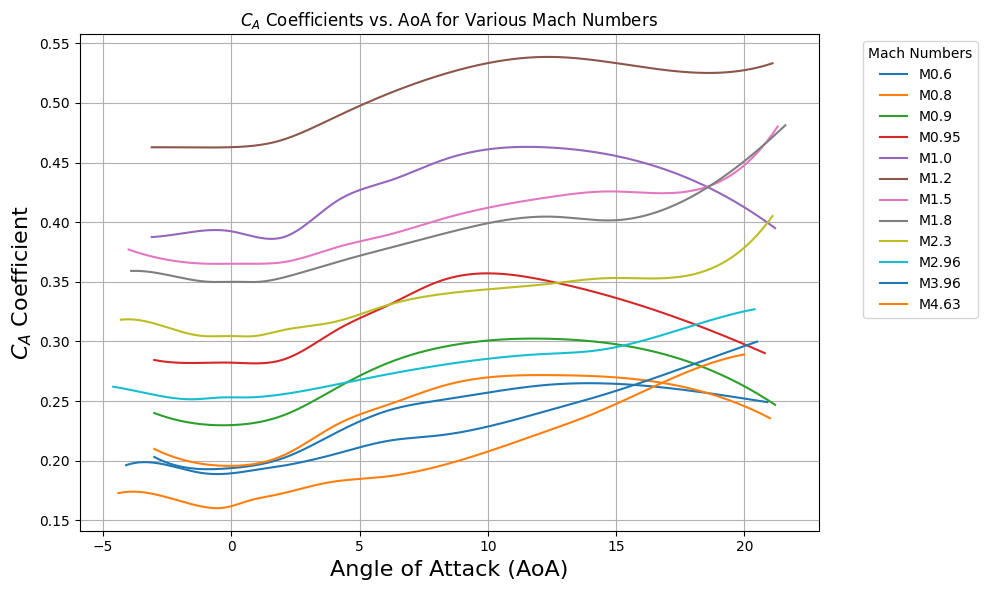

In [18]:
# Extract the Mach number from each column name and sort the columns by Mach number
# Create a list of tuples (mach_number, column_name), sort by mach_number
sorted_columns = sorted([(float(col.split('_')[0][1:]), col) for col in data.columns[1:]])

# Set up the plot
plt.figure(figsize=(10, 6))

# Loop through the sorted Mach number columns
for mach, column in sorted_columns:
    # Extract the AoA and corresponding CA values, removing NaNs
    aoa = data['AoA']
    ca_values = data[column]
    
    # Plot only if there are valid data points
    if ca_values.notna().any():
        plt.plot(aoa, ca_values, label=f"M{mach}")

# Add labels and title
plt.xlabel('Angle of Attack (AoA)',fontsize=16)
plt.ylabel('$C_A$ Coefficient',fontsize=16)
plt.title('$C_A$ Coefficients vs. AoA for Various Mach Numbers')
plt.grid(True)
plt.legend(title='Mach Numbers', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better viewing
plt.tight_layout()

plt.savefig("CA_vs_alpha.png")
plt.savefig("CA_vs_alpha.eps")
plt.savefig("CA_vs_alpha.pdf")

plt.show()

### <ins> $C_A$ coefficient for $\alpha$ = 0$^\circ$ as function of Mach number </ins>

In [19]:
# ### OpenFOAM results ###
# ########################
# # Data for Mach numbers and corresponding CA values for AoA = 0
# OF_data = {
#     0.6: [0.272, 0.373],  # Corresponds to R5 and R1
#     1.0: [0.511, 0.483],  # Corresponds to R5 and R1
#     1.5: [0.481, 0.469],  # Corresponds to R5 and R1
#     2.3: [0.345, 0.334],  # Corresponds to R5 and R1
#     4.63: [0.185, 0.320]  # Corresponds to R5 and R1
# }

# # Extracting Mach numbers and corresponding CA values
# OF_mach_numbers = list(OF_data.keys())
# CA_values_R5 = [values[0] for values in OF_data.values()]  # Select R5 values
# CA_values_R1 = [values[1] for values in OF_data.values()]  # Select R1 values

# ### Fluent results ###
# ######################
# # Data for Mach numbers and corresponding CA values for AoA = 0
# FLUENT_data = {
#     0.6: [0.41, 0.41],  # Corresponds to R5 and R1
#     1.0: [0.4343, 0.4343],  # Corresponds to R5 and R1
#     1.5: [0.3575, 0.3575],  # Corresponds to R5 and R1
#     2.3: [0.2700, 0.2700],  # Corresponds to R5 and R1
#     4.63: [0.1351, 0.1888]  # Corresponds to R5 and R1
#     #4.63: [0.1351, 0.1351]  # Corresponds to R5 and R1
# }

# # Extracting Mach numbers and corresponding CA values
# FLUENT_mach_numbers = list(FLUENT_data.keys())
# CA_values_R5_FLUENT = [values[0] for values in FLUENT_data.values()]  # Select R5 values
# CA_values_R1_FLUENT = [values[1] for values in FLUENT_data.values()]  # Select R1 values

# # Extract the unique AoA values, skipping NaNs
# unique_aoa = data['AoA'].dropna().unique()

# # Select a specific AoA value for demonstration (e.g., index 80)
# selected_aoa_values = unique_aoa[80:81]

# # Iterate over the selected AoA values and plot for each
# for aoa_value in selected_aoa_values:
#     # Extract the CA values for the specific AoA across all Mach numbers
#     ca_values = data[data['AoA'] == aoa_value].iloc[0, 1:]  # Select the row for the AoA and skip the 'AoA' column
    
#     # Extract the Mach numbers from column names and convert them to floats
#     mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
#     ca_values = ca_values.values
    
#     # Sort the Mach numbers and the corresponding C_A values
#     sorted_indices = np.argsort(mach_numbers)
#     mach_numbers = np.array(mach_numbers)[sorted_indices]
#     ca_values = ca_values[sorted_indices]
    
#     # Plotting EXPERIMENTAL results
#     plt.figure(figsize=(8, 5))
#     plt.plot(mach_numbers, ca_values, marker='o', linestyle='-.', color='k', label='EXP.')

#     # Plotting OPENFOAM results
#     #plt.plot(OF_mach_numbers, CA_values_R5, marker='o', label='OF (R5)', color='red')
#     #plt.plot(OF_mach_numbers, CA_values_R1, marker='o', label='OF (R1)', color='green')
#     plt.scatter(OF_mach_numbers, CA_values_R5, marker='x', s=150, label='OF (R5)', color='red')
#     plt.scatter(OF_mach_numbers, CA_values_R1, marker='x', s=150, label='OF (R1)', color='green')
    
#     # Plotting FLUENT results
#     #plt.plot(FLUENT_mach_numbers, CA_values_R5_FLUENT, marker='X', label='FLUENT (R5)', color='k')
#     #plt.plot(FLUENT_mach_numbers, CA_values_R1_FLUENT, marker='X', label='FLUENT (R1)', color='m')
#     #plt.scatter(FLUENT_mach_numbers, CA_values_R5_FLUENT, marker='X', label='FLUENT (R5)', color='b')
#     plt.scatter(FLUENT_mach_numbers, CA_values_R1_FLUENT, marker='p', s=150, label='FLUENT (R1)', color='m')
    
#     # Increase tick label font size
#     plt.tick_params(axis='both', which='major', labelsize=22)  # Major ticks
#     plt.tick_params(axis='both', which='minor', labelsize=22)  # Minor ticks
    
#     plt.xlabel('Mach Number', fontsize=22)
#     plt.ylabel('$C_A$ Coefficient', fontsize=22)
#     plt.title(f'$C_A$ Coefficients at AoA = {aoa_value}°',fontsize=22)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.legend()
#     plt.savefig("CA_alpha0.png")
#     plt.savefig("CA_alpha0.eps")
#     plt.savefig("CA_alpha0.pdf")    
#     plt.show()

In [20]:
# # OpenFOAM results
# OF_data = {
#     0.6:  [0.272, 0.373],  
#     1.0:  [0.511, 0.483],  
#     1.5:  [0.481, 0.469],  
#     2.3:  [0.345, 0.334],  
#     4.63: [0.185, 0.320]  
# }

# OF_mach_numbers = list(OF_data.keys())
# CA_values_R5 = [values[0] for values in OF_data.values()]  
# CA_values_R1 = [values[1] for values in OF_data.values()]  

# # Fluent results for different turbulence models (TODO: fix data)
# FLUENT_data_models = {
#     'k-omega SST': {
#         0.6: [0.6850, 0.6850],
#         1.0: [0.4343, 0.4343],
#         1.5: [0.3575, 0.3575],
#         2.3: [0.2700, 0.2700],
#         4.63: [0.1351, 0.1888]
#     },
#     'Spalart-Allmaras': {
#         0.6: [0.6500, 0.6500],
#         1.0: [0.4200, 0.4200],
#         1.5: [0.3500, 0.3500],
#         2.3: [0.2650, 0.2650],
#         4.63: [0.1300, 0.1850]
#     },
#     'k-epsilon': {
#         0.6: [0.6700, 0.6700],
#         1.0: [0.4300, 0.4300],
#         1.5: [0.3600, 0.3600],
#         2.3: [0.2750, 0.2750],
#         4.63: [0.1400, 0.1900]
#     },
#     'Laminar': {
#         0.6: [0.6400, 0.6400],
#         1.0: [0.4100, 0.4100],
#         1.5: [0.3450, 0.3450],
#         2.3: [0.2600, 0.2600],
#         4.63: [0.1250, 0.1800]
#     },
#     'Pressure-based': {
#         0.6: [0.6600, 0.6600],
#         1.0: [0.4400, 0.4400],
#         1.5: [0.3700, 0.3700],
#         2.3: [0.2800, 0.2800],
#         4.63: [0.1500, 0.1950]
#     }
# }

# # Extract the unique AoA values, skipping NaNs
# unique_aoa = data['AoA'].dropna().unique()

# # Select a specific AoA value for demonstration (e.g., index 80)
# selected_aoa_values = unique_aoa[80:81]

# # Iterate over the selected AoA values and plot for each
# for aoa_value in selected_aoa_values:
#     # Extract the CA values for the specific AoA across all Mach numbers
#     ca_values = data[data['AoA'] == aoa_value].iloc[0, 1:]  # Select the row for the AoA and skip the 'AoA' column
    
#     # Extract the Mach numbers from column names and convert them to floats
#     mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
#     ca_values = ca_values.values
    
#     # Sort the Mach numbers and the corresponding C_A values
#     sorted_indices = np.argsort(mach_numbers)
#     mach_numbers = np.array(mach_numbers)[sorted_indices]
#     ca_values = ca_values[sorted_indices]
    
#     # Plot
#     plt.figure(figsize=(10, 6))
#     plt.plot(mach_numbers, ca_values, marker='o', linestyle='-.', color='k', label='EXP.')

#     # Plotting OF results
#     plt.scatter(OF_mach_numbers, CA_values_R5, marker='x', s=150, label='OF (R5)', color='red')
#     plt.scatter(OF_mach_numbers, CA_values_R1, marker='x', s=150, label='OF (R1)', color='green')
    
#     # Plotting FLUENT results for each turbulence model
#     markers = ['s', 'D', 'v', 'p', 'h']  # Different markers for each model
#     colors = ['blue', 'orange', 'purple', 'brown', 'pink']  # Different colors for each model
#     for (model_name, model_data), marker, color in zip(FLUENT_data_models.items(), markers, colors):
#         mach_numbers_model = list(model_data.keys())
#         ca_values_R5_model = [values[0] for values in model_data.values()]
#         ca_values_R1_model = [values[1] for values in model_data.values()]
        
#         # Plotting the R1 values for simplicity (adjust as needed)
#         plt.scatter(mach_numbers_model, ca_values_R1_model, marker=marker, s=150, label=f'FLUENT ({model_name})', color=color)
    
#     # Increase tick label font size
#     plt.tick_params(axis='both', which='major', labelsize=22)
#     plt.tick_params(axis='both', which='minor', labelsize=22)
    
#     plt.xlabel('Mach Number', fontsize=22)
#     plt.ylabel('$C_A$ Coefficient', fontsize=22)
#     plt.title(f'$C_A$ Coefficients at AoA = {aoa_value}°', fontsize=22)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.legend()
#     plt.savefig(f"CA_alpha_{aoa_value}.png")
#     plt.savefig(f"CA_alpha_{aoa_value}.eps")
#     plt.savefig(f"CA_alpha_{aoa_value}.pdf")    
#     plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


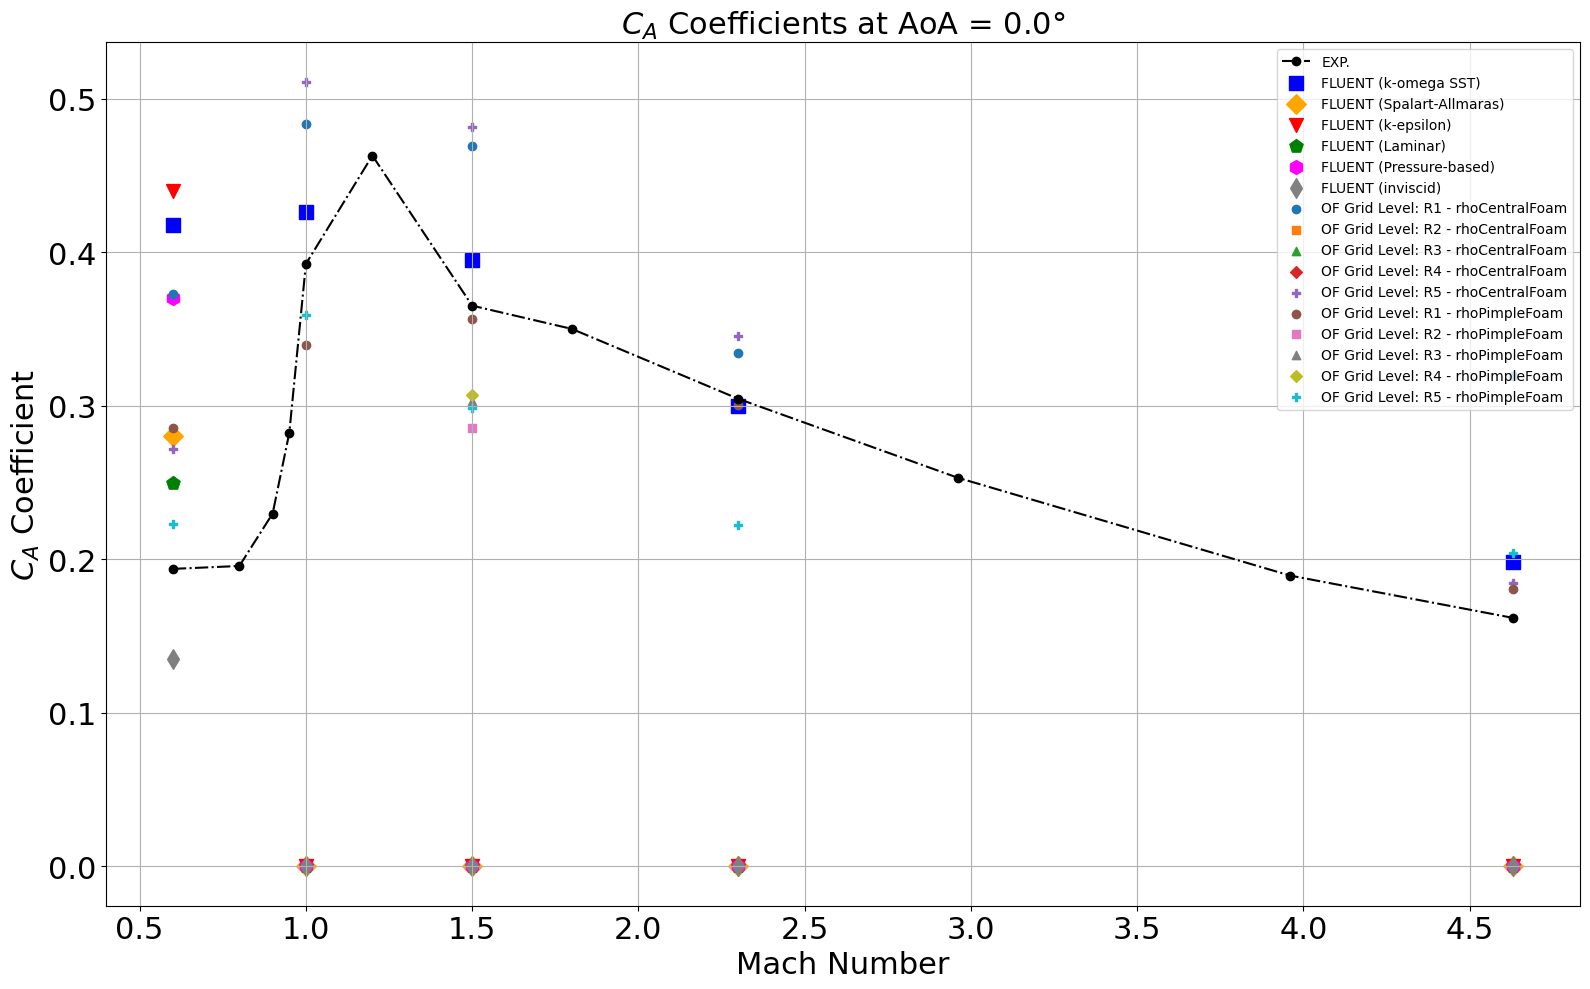

In [21]:
# OpenFOAM results
OF_data = {
    0.6:  [0.272, 0.373],  
    1.0:  [0.511, 0.483],  
    1.5:  [0.481, 0.469],  
    2.3:  [0.345, 0.334],  
    4.63: [0.185, 0.320]  
}

OF_mach_numbers = list(OF_data.keys())
CA_values_R5 = [values[0] for values in OF_data.values()]  
CA_values_R1 = [values[1] for values in OF_data.values()]  

# Fluent results for different turbulence models (example data)
FLUENT_data_models = {
    'k-omega SST': {
        0.6:  [0.4178,0.4178], # Corresponds to R5, R4, R3, R2, R1
        1.0:  [0.4264,0.4199],
        1.5:  [0.3947,0.3947],
        2.3:  [0.2996,0.2996],
        4.63: [0.1982,0.1982]
    },
    'Spalart-Allmaras': {
        0.6:  [0.28, 0.28],
        1.0:  [0.0,0.0],
        1.5:  [0.0,0.0],
        2.3:  [0.0,0.0],
        4.63: [0.0,0.0]
    },
    'k-epsilon': {
        0.6:  [0.44, 0.44],
        1.0:  [0.0,0.0],
        1.5:  [0.0,0.0],
        2.3:  [0.0,0.0],
        4.63: [0.0,0.0]
    },
    'Laminar': {
        0.6: [0.25, 0.25],
        1.0: [0.0,0.0],
        1.5: [0.0,0.0],
        2.3: [0.0,0.0],
        4.63: [0.0,0.0]
    },
    'Pressure-based': {
        0.6:  [0.37, 0.37],
        1.0:  [0.0,0.0],
        1.5:  [0.0,0.0],
        2.3:  [0.0,0.0],
        4.63: [0.0,0.0]
 },
    'inviscid': {
        0.6:  [0.135, 0.135],
        1.0:  [0.0,0.0],
        1.5:  [0.0,0.0],
        2.3:  [0.0,0.0],
        4.63: [0.0,0.0]
    }
}

# Extract the unique AoA values, skipping NaNs
unique_aoa = data['AoA'].dropna().unique()

# Select a specific AoA value for demonstration (e.g., index 80)
selected_aoa_values = unique_aoa[80:81]

# Iterate over the selected AoA values and plot for each
for aoa_value in selected_aoa_values:
    # Extract the CA values for the specific AoA across all Mach numbers
    ca_values = data[data['AoA'] == aoa_value].iloc[0, 1:]  # Select the row for the AoA and skip the 'AoA' column
    
    # Extract the Mach numbers from column names and convert them to floats
    mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
    ca_values = ca_values.values
    
    # Sort the Mach numbers and the corresponding C_A values
    sorted_indices = np.argsort(mach_numbers)
    mach_numbers = np.array(mach_numbers)[sorted_indices]
    ca_values = ca_values[sorted_indices]
    
    # Plot EXPERIMENTAL results
    plt.figure(figsize=(16, 10))
    plt.plot(mach_numbers, ca_values, marker='o', linestyle='-.', color='k', label='EXP.')
    
    # Plotting OPENFOAM results
    #plt.scatter(OF_mach_numbers, CA_values_R5, marker='x', s=200, label='OF (R5)', color='red')
    #plt.scatter(OF_mach_numbers, CA_values_R1, marker='x', s=200, label='OF (R1)', color='green')
    
    # Plotting FLUENT results
    markers = ['s', 'D', 'v', 'p', 'h', "d"]  # Different markers for each model
    colors = ['blue', 'orange', 'red', 'green', 'magenta', 'grey']  # Different colors for each model
    for (model_name, model_data), markers, color in zip(FLUENT_data_models.items(), markers, colors):
        mach_numbers_model = list(model_data.keys())
        ca_values_R1_model = [values[0] for values in model_data.values()]
        ca_values_R5_model = [values[1] for values in model_data.values()]
        
        # Plotting the R1 values for simplicity (adjust as needed)
        plt.scatter(mach_numbers_model, ca_values_R1_model, marker=markers, s=100, label=f'FLUENT ({model_name})', color=color)
        #plt.scatter(mach_numbers_model, ca_values_R5_model, marker=marker, s=100, label=f'FLUENT ({model_name})', color='lime')

        # Calculate the error with respect to experimental values
        error_band = [abs(ca_values[np.argwhere(mach_numbers == mach)[0][0]] - model_value)
                      for mach, model_value in zip(mach_numbers_model, ca_values_R1_model)]
        
        # Adding error bands
        #plt.errorbar(mach_numbers_model, ca_values_R1_model, yerr=error_band, fmt='none', ecolor=color, elinewidth=1.5, capsize=3)
    
    for grid_level, marker in markersdict.items():
        level_data = data_alpha_0[(data_alpha_0['Grid_Refinement'] == grid_level) & (data_alpha_0['Solver'] == 'rhoCentralFoam')]
        plt.scatter(level_data['Mach'], level_data['CA_FINAL_COEFF'], marker=marker, label=f'OF Grid Level: {grid_level} - rhoCentralFoam')

    for grid_level, marker in markersdict.items():
        level_data = data_alpha_0[(data_alpha_0['Grid_Refinement'] == grid_level) & (data_alpha_0['Solver'] == 'rhoPimpleFoam')]
        plt.scatter(level_data['Mach'], level_data['CA_FINAL_COEFF'], marker=marker, label=f'OF Grid Level: {grid_level} - rhoPimpleFoam')
    
    # Increase tick label font size
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.tick_params(axis='both', which='minor', labelsize=22)
    
    plt.xlabel('Mach Number', fontsize=22)
    plt.ylabel('$C_A$ Coefficient', fontsize=22)
    plt.title(f'$C_A$ Coefficients at AoA = {aoa_value}°', fontsize=22)
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"CA_alpha_{aoa_value}.png")
    plt.savefig(f"CA_alpha_{aoa_value}.eps")
    plt.savefig(f"CA_alpha_{aoa_value}.pdf")    
    plt.show()

### <ins> $C_A$ coefficient for $\alpha$ = 8$^\circ$ as function of Mach number </ins>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


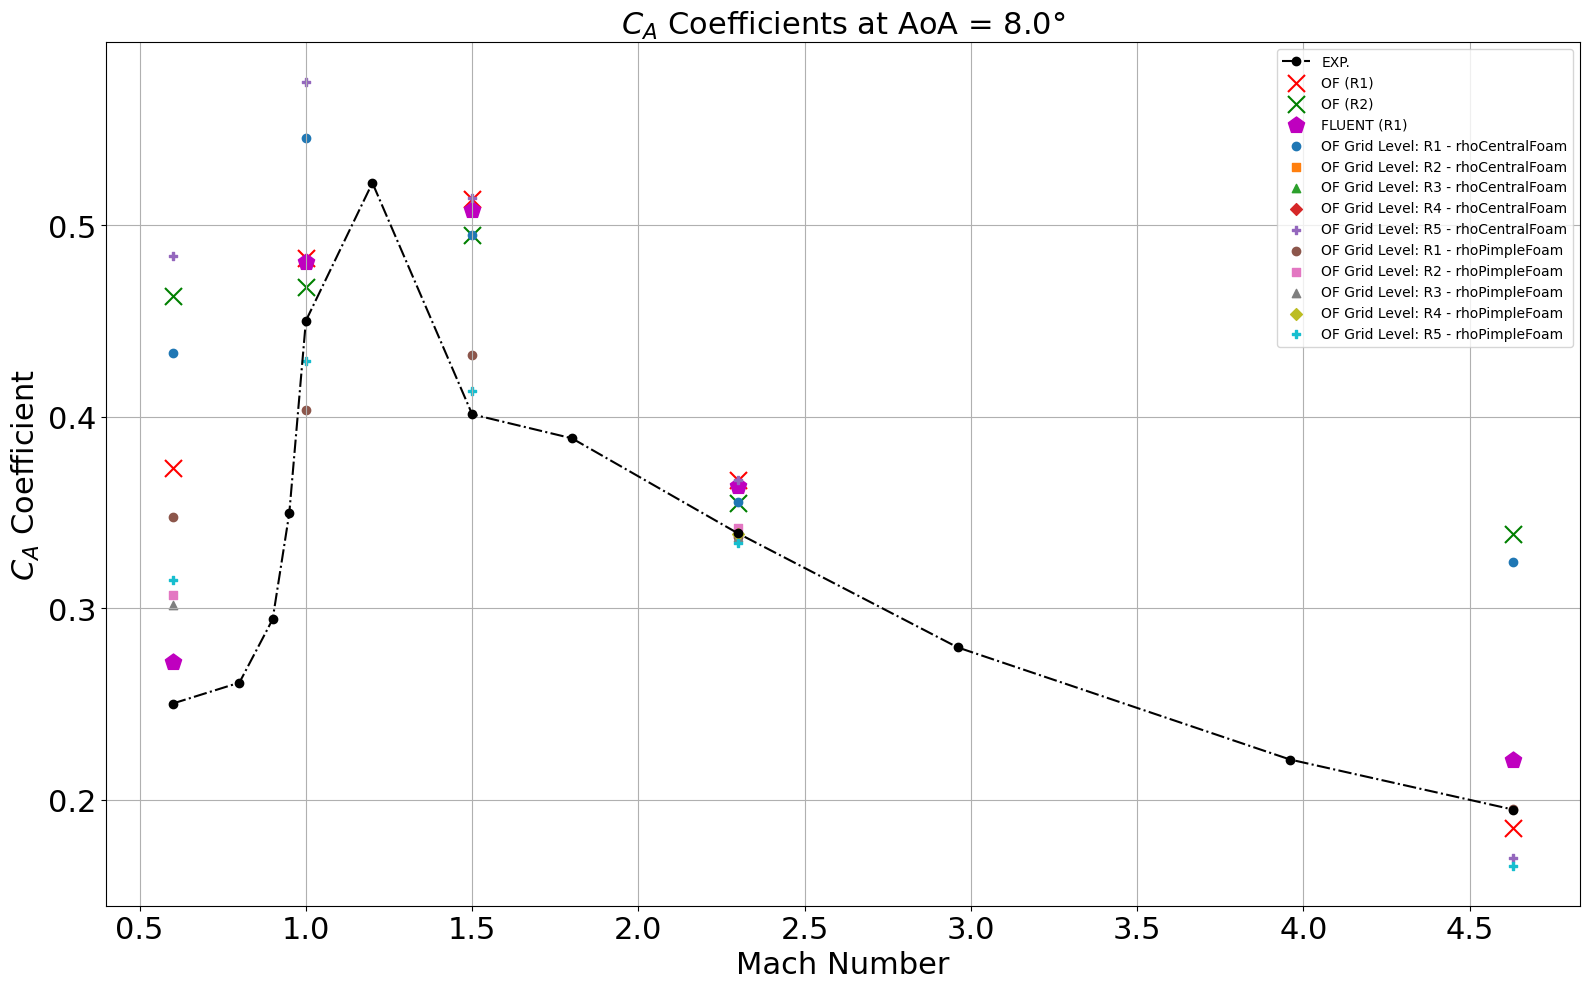

In [22]:
### OpenFOAM results ###
########################
# Data for Mach numbers and corresponding CA values for AoA = 8
OF_data = {
    0.6:  [0.373, 0.463],  # Corresponds to R5 and R1
    1.0:  [0.483, 0.468],  # Corresponds to R5 and R1
    1.5:  [0.514, 0.495],  # Corresponds to R5 and R1
    2.3:  [0.367, 0.355],  # Corresponds to R5 and R1
    4.63: [0.185, 0.339]   # Corresponds to R5 and R1
}

# Extracting Mach numbers and corresponding CA values
OF_mach_numbers = list(OF_data.keys())
CA_values_R1    = [values[0] for values in OF_data.values()]  # Select R1 values
CA_values_R2    = [values[1] for values in OF_data.values()]  # Select R2 values
#CA_values_R3    = [values[2] for values in OF_data.values()]  # Select R3 values

### Fluent results ###
######################
# Data for Mach numbers and corresponding CA values for AoA = 8
FLUENT_data = {
    0.6:  [0.272,  0.373],  # Corresponds to R1, R2, R3, R4, R5
    1.0:  [0.4807, 0.4807], 
    1.5:  [0.5080, 0.5080], 
    2.3:  [0.3637, 0.3637], 
    4.63: [0.2205, 0.2205]   
} 

# Extracting Mach numbers and corresponding CA values
FLUENT_mach_numbers = list(FLUENT_data.keys())
CA_values_R1_FLUENT = [values[0] for values in FLUENT_data.values()]  # Select R1 values
CA_values_R2_FLUENT = [values[1] for values in FLUENT_data.values()]  # Select R2 values
#CA_values_R3_FLUENT = [values[2] for values in FLUENT_data.values()]  # Select R3 values
#CA_values_R4_FLUENT = [values[3] for values in FLUENT_data.values()]  # Select R4 values
#CA_values_R5_FLUENT = [values[4] for values in FLUENT_data.values()]  # Select R5 values

# Extract the unique AoA values, skipping NaNs
unique_aoa = data['AoA'].dropna().unique()

# Select a specific AoA value for demonstration (e.g., index 80)
selected_aoa_values = unique_aoa[160:161]

# Iterate over the selected AoA values and plot for each
for aoa_value in selected_aoa_values:
    # Extract the CA values for the specific AoA across all Mach numbers
    ca_values = data[data['AoA'] == aoa_value].iloc[0, 1:]  # Select the row for the AoA and skip the 'AoA' column
    
    # Extract the Mach numbers from column names and convert them to floats
    mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
    ca_values = ca_values.values
    
    # Sort the Mach numbers and the corresponding C_A values
    sorted_indices = np.argsort(mach_numbers)
    mach_numbers = np.array(mach_numbers)[sorted_indices]
    ca_values = ca_values[sorted_indices]
    
    # Plot
    plt.figure(figsize=(16, 10))
    plt.plot(mach_numbers, ca_values, marker='o', linestyle='-.', color='k', label='EXP.')

    # Plotting OF results
    plt.scatter(OF_mach_numbers, CA_values_R1, marker='x', s=150, label='OF (R1)', color='red')
    plt.scatter(OF_mach_numbers, CA_values_R2, marker='x', s=150, label='OF (R2)', color='green')
    
    # Plotting FLUENT results
    #plt.plot(FLUENT_mach_numbers, CA_values_R5_FLUENT, marker='X', label='FLUENT (R5)', color='k')
    #plt.plot(FLUENT_mach_numbers, CA_values_R1_FLUENT, marker='X', label='FLUENT (R1)', color='m')
    #plt.scatter(FLUENT_mach_numbers, CA_values_R5_FLUENT, marker='X', label='FLUENT (R5)', color='b')
    plt.scatter(FLUENT_mach_numbers, CA_values_R1_FLUENT, marker='p', s=150, label='FLUENT (R1)', color='m')

    for grid_level, marker in markersdict.items():
        level_data = data_alpha_8[(data_alpha_8['Grid_Refinement'] == grid_level) & (data_alpha_8['Solver'] == 'rhoCentralFoam')]
        plt.scatter(level_data['Mach'], level_data['CA_FINAL_COEFF'], marker=marker, label=f'OF Grid Level: {grid_level} - rhoCentralFoam')

    for grid_level, marker in markersdict.items():
        level_data = data_alpha_8[(data_alpha_8['Grid_Refinement'] == grid_level) & (data_alpha_8['Solver'] == 'rhoPimpleFoam')]
        plt.scatter(level_data['Mach'], level_data['CA_FINAL_COEFF'], marker=marker, label=f'OF Grid Level: {grid_level} - rhoPimpleFoam')
    
    # Increase tick label font size
    plt.tick_params(axis='both', which='major', labelsize=22)  # Major ticks
    plt.tick_params(axis='both', which='minor', labelsize=22)  # Minor ticks
    
    plt.xlabel('Mach Number', fontsize=22)
    plt.ylabel('$C_A$ Coefficient', fontsize=22)
    plt.title(f'$C_A$ Coefficients at AoA = {aoa_value}°', fontsize=22)
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.savefig("CA_alpha8.png")
    plt.savefig("CA_alpha8.eps")
    plt.savefig("CA_alpha8.pdf")
    plt.show()

### <ins> $C_A$ coefficient for $\alpha$ = 16$^\circ$ as function of Mach number </ins>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


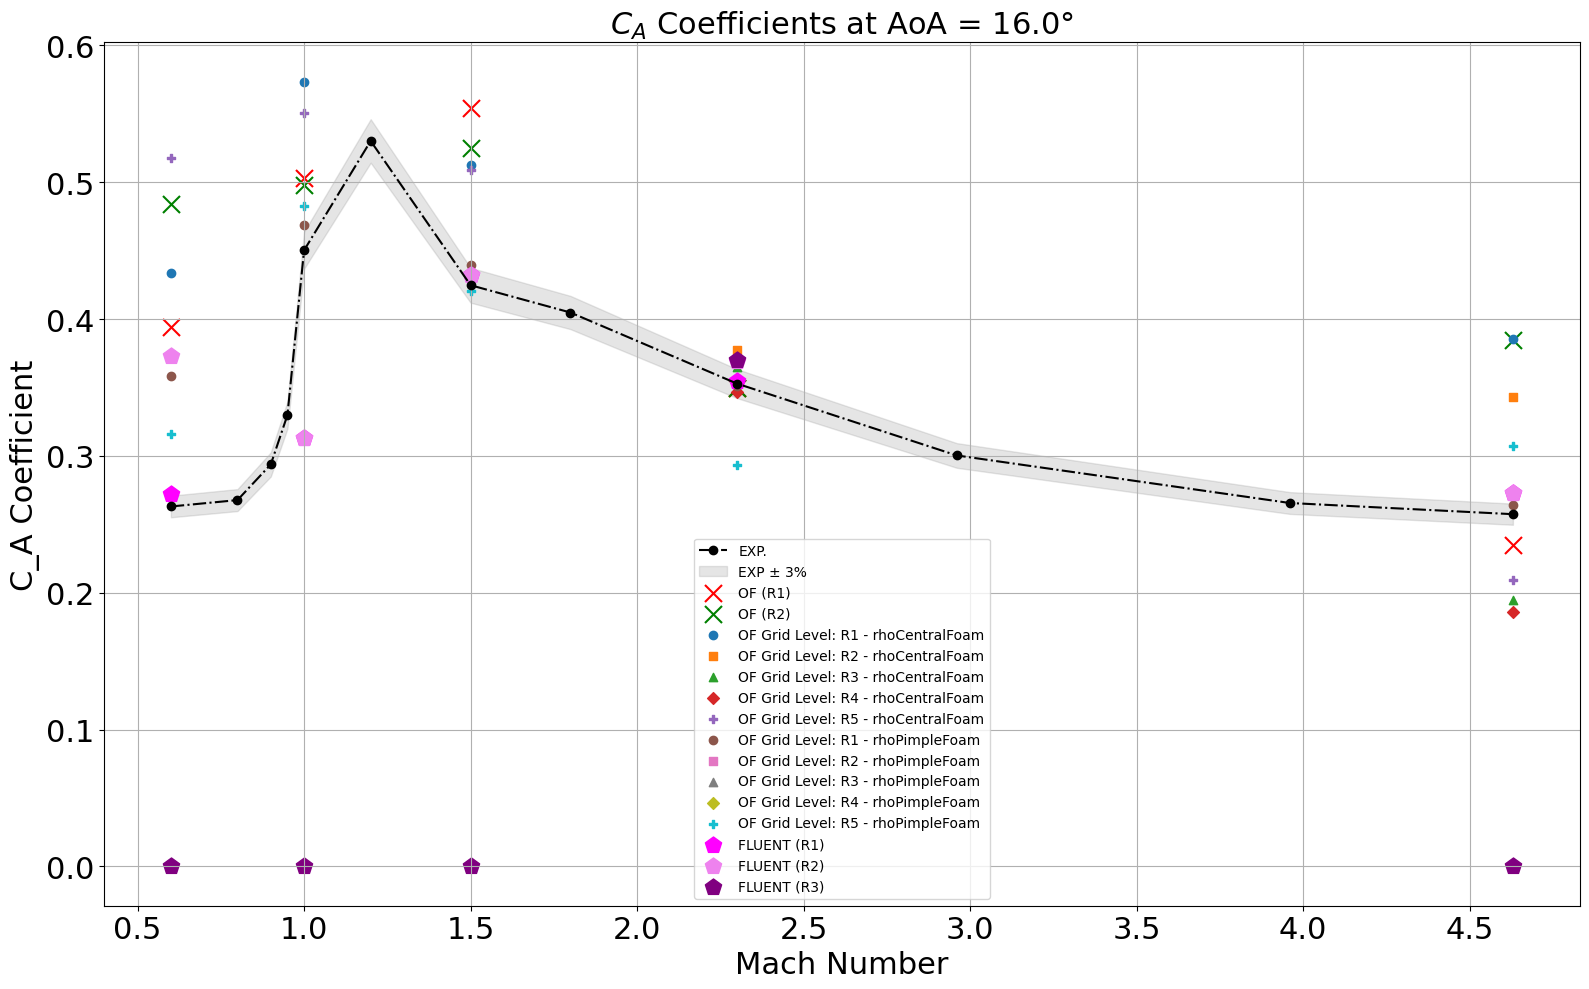

In [23]:
### OpenFOAM results ###
########################
# Data for Mach numbers and corresponding CA values for AoA = 16
OF_data = {
    0.6:  [0.394, 0.484], # Placeholder values for AoA = 16
    1.0:  [0.503, 0.498], # Placeholder values for AoA = 16
    1.5:  [0.554, 0.525], # Placeholder values for AoA = 16
    2.3:  [0.35, 0.35],   # Placeholder values for AoA = 16
    4.63: [0.235, 0.385]  # Placeholder values for AoA = 16
}

# Extracting Mach numbers and corresponding CA values
OF_mach_numbers = list(OF_data.keys())
CA_values_R1 = [values[0] for values in OF_data.values()]  # Select R1 values
CA_values_R2 = [values[1] for values in OF_data.values()]  # Select R2 values
#CA_values_R3 = [values[2] for values in OF_data.values()]  # Select R3 values
#CA_values_R5 = np.array([float(values[0]) for values in OF_data.values()])  # Ensure float conversion
#CA_values_R1 = np.array([float(values[1]) for values in OF_data.values()])  # Ensure float conversion

# Calculating 3% error margins
#error_margin_R5 = CA_values_R5 * 0.03
#error_margin_R1 = CA_values_R1 * 0.03

### Fluent results ###
######################
# Data for Mach numbers and corresponding CA values for AoA = 16
FLUENT_data = {
    0.6:  [0.272,  0.373,  0.000],  # Corresponds to R1, R2, R3, R4, R5
    1.0:  [0.3133, 0.3133, 0.000], 
    1.5:  [0.4319, 0.4319, 0.000],
    2.3:  [0.3551, 0.3693, 0.370], 
    4.63: [0.2730, 0.2730, 0.000] 
}

# Extracting Mach numbers and corresponding CA values
FLUENT_mach_numbers = list(FLUENT_data.keys())
CA_values_R1_FLUENT = [values[0] for values in FLUENT_data.values()]  # Select R1 values
CA_values_R2_FLUENT = [values[1] for values in FLUENT_data.values()]  # Select R2 values
CA_values_R3_FLUENT = [values[2] for values in FLUENT_data.values()]  # Select R3 values

# Extract the unique AoA values, skipping NaNs
unique_aoa = data['AoA'].dropna().unique()

# Select a specific AoA value for demonstration (e.g., index 80)
selected_aoa_values = unique_aoa[240:241]

# Iterate over the selected AoA values and plot for each
for aoa_value in selected_aoa_values:
    # Extract the CA values for the specific AoA across all Mach numbers
    ca_values = data[data['AoA'] == aoa_value].iloc[0, 1:]  # Select the row for the AoA and skip the 'AoA' column
    
    # Extract the Mach numbers from column names and convert them to floats
    mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
    ca_values = ca_values.values
    
    # Sort the Mach numbers and the corresponding C_A values
    sorted_indices = np.argsort(mach_numbers)
    mach_numbers = np.array(mach_numbers)[sorted_indices]
    ca_values = ca_values[sorted_indices]
    
    # Plot
    plt.figure(figsize=(16, 10))
    plt.plot(mach_numbers, ca_values, marker='o', linestyle='-.', color='k', label='EXP.')

    # Calculating 3% error margins
    error_margin = ca_values * 0.03
    plt.fill_between(mach_numbers, ca_values - error_margin, ca_values + error_margin, color='gray', alpha=0.2, label="EXP ± 3%")

    # Plotting OF results
    plt.scatter(OF_mach_numbers, CA_values_R1, marker='x', s=150, label='OF (R1)', color='red')
    plt.scatter(OF_mach_numbers, CA_values_R2, marker='x', s=150, label='OF (R2)', color='green')

    # Plotting OF results with error bands
    #plt.fill_between(OF_mach_numbers, CA_values_R5 - error_margin_R5, CA_values_R5 + error_margin_R5, color='red', alpha=0.2, label="OF (R5) ± 3%")
    #plt.fill_between(OF_mach_numbers, CA_values_R1 - error_margin_R1, CA_values_R1 + error_margin_R1, color='green', alpha=0.2, label="OF (R1) ± 3%")
    
    for grid_level, marker in markersdict.items():
        level_data = data_alpha_16[(data_alpha_16['Grid_Refinement'] == grid_level) & (data_alpha_16['Solver'] == 'rhoCentralFoam')]
        plt.scatter(level_data['Mach'], level_data['CA_FINAL_COEFF'], marker=marker, label=f'OF Grid Level: {grid_level} - rhoCentralFoam')

    for grid_level, marker in markersdict.items():
        level_data = data_alpha_16[(data_alpha_16['Grid_Refinement'] == grid_level) & (data_alpha_16['Solver'] == 'rhoPimpleFoam')]
        plt.scatter(level_data['Mach'], level_data['CA_FINAL_COEFF'], marker=marker, label=f'OF Grid Level: {grid_level} - rhoPimpleFoam')

    # Plotting FLUENT results
    plt.scatter(FLUENT_mach_numbers, CA_values_R1_FLUENT, marker='p', s=150, label='FLUENT (R1)', color='magenta')
    plt.scatter(FLUENT_mach_numbers, CA_values_R2_FLUENT, marker='p', s=150, label='FLUENT (R2)', color='violet')
    plt.scatter(FLUENT_mach_numbers, CA_values_R3_FLUENT, marker='p', s=150, label='FLUENT (R3)', color='purple')

    # Increase tick label font size
    plt.tick_params(axis='both', which='major', labelsize=22)  # Major ticks
    plt.tick_params(axis='both', which='minor', labelsize=22)  # Minor ticks
    
    plt.xlabel('Mach Number', fontsize=22)
    plt.ylabel('C_A Coefficient', fontsize=22)
    plt.title(f'$C_A$ Coefficients at AoA = {aoa_value}°', fontsize=22)
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.savefig("CA_alpha16.png")
    plt.savefig("CA_alpha16.eps")
    plt.savefig("CA_alpha16.pdf")
    plt.show()

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import re

# OpenFOAM results
OF_data = {
    0.6:  [0.394, 0.484],
    1.0:  [0.503, 0.498],
    1.5:  [0.554, 0.525],
    2.3:  [0.35, 0.35],
    4.63: [0.235, 0.385]
}

# Extracting Mach numbers and corresponding CA values
OF_mach_numbers = list(OF_data.keys())
CA_values_R1 = np.array([values[0] for values in OF_data.values()])
CA_values_R2 = np.array([values[1] for values in OF_data.values()])

# Fluent results
FLUENT_data = {
    0.6:  [0.272,  0.373,  0.000],
    1.0:  [0.3133, 0.3133, 0.000],
    1.5:  [0.4319, 0.4319, 0.000],
    2.3:  [0.3551, 0.3693, 0.370],
    4.63: [0.2730, 0.2730, 0.000]
}

# Extracting Mach numbers and corresponding CA values
FLUENT_mach_numbers = list(FLUENT_data.keys())
CA_values_R1_FLUENT = np.array([values[0] for values in FLUENT_data.values()])  
CA_values_R2_FLUENT = np.array([values[1] for values in FLUENT_data.values()])  
CA_values_R3_FLUENT = np.array([values[2] for values in FLUENT_data.values()])  

# Extract the unique AoA values, skipping NaNs
unique_aoa = data['AoA'].dropna().unique()
selected_aoa_values = unique_aoa[240:241]  # Select a specific AoA value for demonstration

# Iterate over the selected AoA values and plot for each
for aoa_value in selected_aoa_values:
    # Extract the CA values for the specific AoA across all Mach numbers
    ca_values = data[data['AoA'] == aoa_value].iloc[0, 1:]  # Select the row for the AoA and skip the 'AoA' column
    mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
    ca_values = ca_values.values
    
    # Sort the Mach numbers and the corresponding C_A values
    sorted_indices = np.argsort(mach_numbers)
    mach_numbers = np.array(mach_numbers)[sorted_indices]
    ca_values = ca_values[sorted_indices]
    
    # Calculate percentage error margins
    OF_percentage_error_R1 = np.abs(ca_values - CA_values_R1) / np.abs(ca_values) * 100
    FLUENT_percentage_error_R1 = np.abs(ca_values - CA_values_R1_FLUENT) / np.abs(ca_values) * 100
    
    # Plotting setup for percentage error margins
    plt.figure(figsize=(10, 6))
    width = 0.35  # Width of the bars
    x = np.arange(len(mach_numbers))  # Label locations

    # Create bar plots for percentage error margins
    bars1 = plt.bar(x - width/2, OF_percentage_error_R1, width, label='OF (R1) - EXP Margin (%)', color='green', alpha=0.7)
    bars2 = plt.bar(x + width/2, FLUENT_percentage_error_R1, width, label='FLUENT (R1) - EXP Margin (%)', color='magenta', alpha=0.7)

    # Axes labels, title, and ticks
    plt.xlabel('Mach Number', fontsize=22)
    plt.ylabel('Percentage Error Margin (%)', fontsize=22)
    plt.title(f'Percentage Error Margins of $C_A$ Coefficients at AoA = {aoa_value}°', fontsize=22)
    plt.xticks(x, mach_numbers)  # Set the x-ticks to the Mach numbers
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Save and show the plot
    plt.tight_layout()
    plt.savefig("CA_PercentageErrorMargins_alpha16.png")
    plt.savefig("CA_PercentageErrorMargins_alpha16.eps")
    plt.savefig("CA_PercentageErrorMargins_alpha16.pdf")
    plt.show()

ValueError: operands could not be broadcast together with shapes (12,) (5,) 

### $C_A$ coefficient for all $\alpha$ value as function of Mach number.

#### Absent values are skipped and reported.

In [ ]:
# Extract the unique AoA values, skipping NaNs
unique_aoa = data['AoA'].dropna().unique()

# Select AoA values starting from the first one and then every 10th value
selected_aoa_values = unique_aoa[::10]  # Slices every 10th element from the array

# Iterate over the selected AoA values and plot for each
for aoa_value in selected_aoa_values:
    # Extract the CA values for the specific AoA across all Mach numbers
    ca_values = data[data['AoA'] == aoa_value].iloc[0, 1:]  # Select the row for the AoA and skip the 'AoA' column
    
    # Check if there are any valid CA values (not all NaN)
    if ca_values.notna().any():
        # Extract only the numeric part of the Mach number from column names using regex
        mach_numbers = [float(re.findall(r"[-+]?\d*\.?\d+", col)[0]) for col in data.columns[1:]]
        ca_values = ca_values.values
        
        # Sort the Mach numbers and C_A values together
        sorted_indices = np.argsort(mach_numbers)
        mach_numbers = np.array(mach_numbers)[sorted_indices]
        ca_values = ca_values[sorted_indices]
        
        # Plot
        #plt.figure(figsize=(8, 5))
        #plt.plot(mach_numbers, ca_values, marker='o', linestyle='-', color='b')
        #plt.xlabel('Mach Number')
        #plt.ylabel(r'$C_A$ Coefficient')  # Using LaTeX for C_A
        #plt.title(r'$C_A$ Coefficients at AoA = ' + f'{aoa_value}°')
        #plt.grid(True)
        #plt.tight_layout()
        #plt.show()
    else:
        print(f"No valid C_A values for AoA = {aoa_value}°; skipping this plot.")

In [ ]:
# # Generate a normally distributed dataset
# np.random.seed(0)  # for reproducibility
# data = np.random.normal(loc=100, scale=5, size=1000)  # mean = 100, std = 5

# # Calculate mean and standard deviation
# mean = np.mean(data)
# std_dev = np.std(data)

# # Calculate 3-sigma range
# lower_bound = mean - 3 * std_dev
# upper_bound = mean + 3 * std_dev

# # Identify points within and outside the 3-sigma range
# within_3sigma = data[(data >= lower_bound) & (data <= upper_bound)]
# outside_3sigma = data[(data < lower_bound) | (data > upper_bound)]

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.hist(data, bins=30, color='lightblue', edgecolor='black', alpha=0.7, label='Data')
# plt.axvline(mean, color='blue', linestyle='dashed', linewidth=1, label='Mean')
# plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='3-Sigma Lower Bound')
# plt.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='3-Sigma Upper Bound')
# plt.legend()

# # Show results
# print(f"Mean: {mean:.2f}")
# print(f"Standard Deviation: {std_dev:.2f}")
# print(f"3-Sigma Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
# print(f"Data within 3-sigma: {len(within_3sigma)} points ({len(within_3sigma)/len(data)*100:.2f}%)")
# print(f"Data outside 3-sigma: {len(outside_3sigma)} points ({len(outside_3sigma)/len(data)*100:.2f}%)")

# plt.xlabel("Data values")
# plt.ylabel("Frequency")
# plt.title("Data Distribution with 3-Sigma Range")
# plt.show()

In [ ]:
# Plot Ca vs Mach for R1 grid level
plt.figure(figsize=(10, 6))
plt.scatter(data_alpha_0['Mach'], data_alpha_0['CA_FINAL_COEFF'], marker='o', linestyle='-', color='b', label='R1 Grid Level')
plt.xlabel('Mach Number')
plt.ylabel('Axial Force Coefficient (Ca)')
plt.title('Ca vs Mach for R1 Grid Level')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Plot Ca vs Mach for R1 grid level
plt.figure(figsize=(10, 6))
plt.scatter(data_alpha_8['Mach'], data_alpha_8['CA_FINAL_COEFF'], marker='o', linestyle='-', color='b', label='R1 Grid Level')
plt.xlabel('Mach Number')
plt.ylabel('Axial Force Coefficient (Ca)')
plt.title('Ca vs Mach for R1 Grid Level')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Plot Ca vs Mach for R1 grid level
plt.figure(figsize=(10, 6))
plt.scatter(data_alpha_16['Mach'], data_alpha_16['CA_FINAL_COEFF'], marker='o', linestyle='-', color='b', label='R1 Grid Level')
plt.xlabel('Mach Number')
plt.ylabel('Axial Force Coefficient (Ca)')
plt.title('Ca vs Mach for R1 Grid Level')
plt.grid()
plt.legend()
plt.show()